In [3]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
import tools
from math import sqrt
from script.tools import tools
#from script.collection import Parameter as pmt
import sys
print(sys.executable)
import net
import os
from script.tools import collection
#result = collection.collection("collection/workspace1")  #[iops,dic_ssd,dic_worload,f.path]
#result = collection.collection("collection/workspace2",result)
result = collection.collection("collection/workspace_ssd0_workload0")
result = result[:1000]
plst = collection.getParameters(path="collection/config.xlsx",id = "0")
expect = ['Seed','key','default']

/opt/homebrew/anaconda3/bin/python
no scenario collection/workspace_ssd0_workload0/1854/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/425/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/866/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/1994/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/1702/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/428/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/3472/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/1796/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/2148/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/2918/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/3981/workload_scenario_1.xml
no scenario collection/workspace_ssd0_workload0/2456/workload_scenario_1.xml
no scenario collection/workspace_ssd0_worklo

/opt/homebrew/anaconda3/lib/python3.9/site-packages/openpyxl/reader/excel.py:237: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


In [9]:
def test(x_,y_,m, mean = 0,std = 1):
    x_ = (x_ - mean)/std
    y_pre = m(x_)
    y_e = abs(y_pre - y_)/y_
    print(torch.sum(y_e)/len(y_))

In [11]:
#print(result[0])
from script.tools import collection
split_index = int(len(result)*0.7)
train_result = result[:split_index]
test_result  = result[split_index:]
x_train_lst, y_train_lst, keys = collection.result2lst(train_result,plst,expect)
x_test_lst,  y_test_lst, keys = collection.result2lst(test_result,plst,expect)
x_train_tensor = torch.tensor(  x_train_lst  , dtype=torch.float)
y_train_tensor = torch.tensor(  y_train_lst  , dtype=torch.float)/10000
x_test_tensor =  torch.tensor(  x_test_lst   , dtype=torch.float)
y_test_tensor =  torch.tensor(  y_test_lst   , dtype=torch.float)/10000
x_mean = x_train_tensor.mean(dim = 0)
x_std = x_train_tensor.std(dim = 0)
x_train_tensor_nor = (x_train_tensor -x_mean)/x_std

dataset = collection.CustomDataset(x_train_tensor_nor, y_train_tensor)
batch_size = 5
dataloader = collection.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = net.DeepNet(19,8,1,5)
criterion = nn.MSELoss()
print(len(keys))

19


In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
lambda_l2 = 2e-6
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0.0
    i = 0
    for batch_x, batch_y in dataloader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        l2_regularization = torch.tensor(0.)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
            loss = loss + l2_regularization * lambda_l2
        i = i + 1
        if i == -1:
            print("i=------"+str(i),"\n outputs: ",outputs,"\n y:",batch_y)
        total_loss += loss.item()
        if False:
            print("   \n \n")
            print(" outputs: ", outputs)
            print(" batch_y", batch_y)
            print(" loss ", loss)
            print("   \n \n")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        average_loss = total_loss / len(dataloader)
        #print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')
        print("test:")
        test(x_test_tensor,y_test_tensor,model,x_mean,x_std) # test准确度

Epoch [100/500], Loss: 0.001148
test:
tensor(0.2089, grad_fn=<DivBackward0>)
Epoch [200/500], Loss: 0.001203
test:
tensor(0.1919, grad_fn=<DivBackward0>)
Epoch [300/500], Loss: 0.001191
test:
tensor(0.2010, grad_fn=<DivBackward0>)
Epoch [400/500], Loss: 0.001291
test:
tensor(0.2244, grad_fn=<DivBackward0>)
Epoch [500/500], Loss: 0.001122
test:
tensor(0.1935, grad_fn=<DivBackward0>)


In [17]:

# 训练集
print("train")
test(x_train_tensor,y_train_tensor,model,x_mean,x_std)
print("\n \n test:")
test(x_test_tensor,y_test_tensor,model,x_mean,x_std) # test
#print(x_train_tensor[0],model(x_train_tensor_nor[0]),y_train_tensor[0])
print("\n \n")

id = 20
print("out:",y_test_tensor[id])
print(model( (x_test_tensor-x_mean)/x_std )[id])


train
tensor(0.1038, grad_fn=<DivBackward0>)

 
 test:
tensor(0.1935, grad_fn=<DivBackward0>)

 

out: tensor([0.9519])
tensor([0.6688], grad_fn=<SelectBackward0>)


In [44]:
xlst,ylst,keys = collection.result2lst(result,plst,expect)
test_result = collection.collection("collection/workspace")
x_test_lst,y_test_lst,keys = collection.result2lst(test_result,plst,expect)
x_tensor = torch.tensor(xlst,dtype=torch.float)
y_tensor = torch.tensor(ylst,dtype=torch.float)
x_test_tensor =  torch.tensor(x_test_lst,dtype = torch.float)
y_test_tensor =  torch.tensor(y_test_lst,dtype = torch.float)

model = net.DeepNet(48,48,1,5)
criterion = nn.MSELoss()


no scenario collection/workspace/28/workload_scenario_1.xml
no scenario collection/workspace/30/workload_scenario_1.xml
collection:  6
total : 8


tensor(0.1858, grad_fn=<DivBackward0>)
tensor(0.1858, grad_fn=<DivBackward0>)
hhhh
tensor(0.1858, grad_fn=<DivBackward0>)
[1.10065703e-12]
[1.37690466e-14]
[1.39322288e-13]
[9.04947148e-14]
[3.28647857e-12]
[3.28051637e-12]
[6.56141379e-12]
[8.88436406e-13]
[3.44096348e-13]
[1.07245828e-12]
[5.91481375e-13]
[5.41586775e-13]
[2.43243363e-12]
[1.64462792e-12]
[5.77635005e-12]
[1.69846864e-12]
[5.03830087e-13]
[4.52895305e-12]
[3.5120288e-12]
[4.01441819e-12]
[7.66475538e-13]
[2.13279559e-13]
[3.11810475e-12]
[3.04515042e-14]
[5.65573944e-13]
[5.93859787e-12]
[7.95261276e-13]
[5.11522482e-13]
[3.81249521e-13]
[4.50796879e-13]
[1.58939708e-12]
[6.04229677e-13]
[5.6358989e-13]
[1.34774636e-12]
[2.91231997e-12]
[9.822822e-13]
[1.06311109e-11]
[1.50110257e-13]
[1.85993381e-12]
[1.59747386e-11]
[6.68745034e-13]
[1.4662359e-12]
[2.6859494e-12]
[1.66427863e-13]
[2.30576133e-12]
[1.523033e-13]
[2.98361836e-13]
[2.48206803e-12]
[6.40941598e-13]
[6.41586304e-13]
[2.70944931e-12]
[9.68733618e-12]
[4

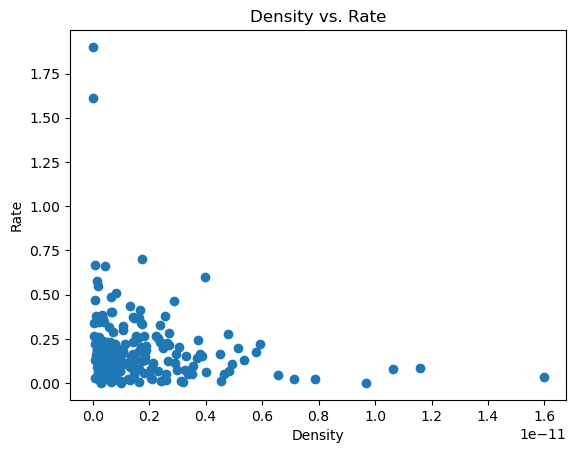

In [104]:
#x_ytensor = torch.tensor(xylst,dtype=torch.float)
# 计算均值和标准差
x_mean = x_tensor.mean(dim=0)
x_std = x_tensor.std(dim=0)
y_mean = y_tensor.mean(dim=0)
y_std = y_tensor.std(dim=0)

# 归一化 x 和 y
normalized_x = (x_tensor - x_mean) / x_std
normalized_y = (y_tensor - y_mean) / y_std
normalized_y_std = y_tensor  / y_std


tree_ssd,rootssd = tools.getTree("collection/ssdconfig.xml")
tree_workload,root_workload = tools.getTree("collection/workload.xml")
i = 0
for key in keys:
    default = tools.getext(rootssd,key)
    if default == None:
        default = tools.getext(root_workload,key)
    print(key,"default: ", default," mean:",str(x_mean[i].item())," std：",x_std[i].item())
    i = i + 1



In [107]:
model = net.DeepNet(48,48,1,5)
#device = torch.device("mps")
#device = torch.device("cpu")
#model.to(device)
criterion = nn.MSELoss()

model_0.0982.pth  exists


<All keys matched successfully>

In [108]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# dataset = CustomDataset(x_tensor, y_tensor)
y_modified = y_tensor/y_mean
dataset = CustomDataset(normalized_x, y_modified)
batch_size = 5
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#optimizer = optim.SGD(model.parameters(), lr=0.001)




tensor([[0.5618],
        [0.1125],
        [0.2550],
        [0.0654],
        [0.0771],
        [0.3035],
        [0.4796],
        [0.3741],
        [0.1920],
        [0.1301],
        [0.1324],
        [0.4283],
        [0.1418],
        [0.2323],
        [0.2001],
        [0.0292],
        [0.2910],
        [0.5038],
        [0.0850],
        [0.6712],
        [0.5066],
        [1.9664],
        [0.0620],
        [0.1514],
        [0.5173],
        [0.3189],
        [0.6853],
        [0.4222],
        [0.2690],
        [0.2659],
        [0.0697],
        [0.4649],
        [0.3005],
        [0.7437],
        [0.2272],
        [0.3342],
        [0.2523],
        [0.8178],
        [0.1258],
        [0.1817],
        [0.6557],
        [0.3641],
        [0.0528],
        [0.6096],
        [0.2518],
        [0.9682],
        [0.1117],
        [0.3666],
        [0.0466],
        [0.1309],
        [0.2234],
        [0.1421],
        [0.2673],
        [0.4538],
        [0.1944],
        [1

In [52]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 1000

loss_history = []
for epoch in range(num_epochs):
    total_loss = 0.0
    i = 0
    for batch_x, batch_y in dataloader:
        #print("hhhh ")
        #print(batch_x,batch_x)
        #i = i +1
        #print(batch_x,"\n",batch_y)
        #print("zzzzzzz")
        # 前向传播

        outputs = model(batch_x)
        #print("batch_x",batch_x[0],"\n outputs: ",outputs[0])
        loss = criterion(outputs, batch_y)
        i = i +1
        if i == -1:
            print("i=------"+str(i),"\n outputs: ",outputs,"\n y:",batch_y)
        total_loss += loss.item()
        if False:
            print("   \n \n")
            print(" outputs: ", outputs)
            print(" batch_y", batch_y)
            print(" loss ", loss)

            print("   \n \n")
        #print(f'Epoch [{epoch+1}/{num_epochs}]')
        #print("loss:",loss.item(),"batch_x: ",batch_x," outputs ",outputs," batch_y: ",batch_y)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #loss_history.append(total_loss)
    # 打印训练信息
    if (epoch+1) % 10 == 0:
        average_loss = total_loss / len(dataloader)
        #print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')

def test(x_,y_,m,rate_y, mean_x = 0,std_x = 1):
    x_ = (x_ - mean_x)/std_x
    y_pre = m(x_)*rate_y
    y_e = abs(y_pre - y_)/y_
    print(torch.sum(y_e)/len(y_))
# 训练集
test(x_tensor,y_tensor,model,y_mean,x_mean,x_std)

print("\n \n test:")
test(x_test_tensor,y_test_tensor,model,y_mean,x_std)



Epoch [10/1000], Loss: 0.000246
Epoch [20/1000], Loss: 0.000245
Epoch [30/1000], Loss: 0.000244
Epoch [40/1000], Loss: 0.000242
Epoch [50/1000], Loss: 0.000242
Epoch [60/1000], Loss: 0.000240
Epoch [70/1000], Loss: 0.000240
Epoch [80/1000], Loss: 0.000239
Epoch [90/1000], Loss: 0.000237
Epoch [100/1000], Loss: 0.000237
Epoch [110/1000], Loss: 0.000236
Epoch [120/1000], Loss: 0.000235
Epoch [130/1000], Loss: 0.000235
Epoch [140/1000], Loss: 0.000234
Epoch [150/1000], Loss: 0.000233
Epoch [160/1000], Loss: 0.000232
Epoch [170/1000], Loss: 0.000231
Epoch [180/1000], Loss: 0.000229
Epoch [190/1000], Loss: 0.000229
Epoch [200/1000], Loss: 0.000228
Epoch [210/1000], Loss: 0.000228
Epoch [220/1000], Loss: 0.000226
Epoch [230/1000], Loss: 0.000225
Epoch [240/1000], Loss: 0.000225
Epoch [250/1000], Loss: 0.000223
Epoch [260/1000], Loss: 0.000223
Epoch [270/1000], Loss: 0.000221
Epoch [280/1000], Loss: 0.000220
Epoch [290/1000], Loss: 0.000220
Epoch [300/1000], Loss: 0.000219
Epoch [310/1000], L

In [57]:
import numpy as np
y_predict_train = model(normalized_x)
y_err = (y_predict_train - y_modified)/y_modified
print(torch.sum(abs(y_err))/len(y_predict))

def test(x_,y_,m,rate_y, mean_x = 0,std_x = 1):
    x_ = (x_ - mean_x)/std_x
    y_pre = m(x_)*rate_y
    y_e = abs(y_pre - y_)/y_
    print(torch.sum(y_e)/len(y_))
# 训练集
test(x_tensor,y_tensor,model,y_mean,x_mean,x_std)

print("\n \n test:")
test(x_test_tensor,y_test_tensor,model,y_mean,x_std)
#print(len(x_tensor))
# 测试集



tensor(0.2114, grad_fn=<DivBackward0>)
tensor(0.2114, grad_fn=<DivBackward0>)

 
 test:
tensor(1.3245, grad_fn=<DivBackward0>)


In [16]:
result1 = []
result1 = collection.collection("collection/workspace",result1)

collection:  1070


In [48]:
#print(xlst[0])
print(len(xlst[0]))
tx = []
tx.append(keys)
i = 0
for y_ in ylst:
    x_ = xlst[i].copy()
    x_.append(y_[0])
    tx.append(x_)
    i = i + 1
print(tx[0])
tools.lst2excel(tx,"test.xlsx")

48
['PCIe_Lane_Bandwidth', 'PCIe_Lane_Count', 'SATA_Processing_Delay', 'Queue_Fetch_Size', 'Data_Cache_DRAM_Row_Size', 'Data_Cache_DRAM_Data_Rate', 'Data_Cache_DRAM_Data_Busrt_Size', 'Data_Cache_DRAM_tRCD', 'Data_Cache_DRAM_tCL', 'Data_Cache_DRAM_tRP', 'Overprovisioning_Ratio', 'GC_Exec_Threshold', 'Preferred_suspend_erase_time_for_read', 'Preferred_suspend_erase_time_for_write', 'Preferred_suspend_write_time_for_read', 'Flash_Channel_Count', 'Flash_Channel_Width', 'Channel_Transfer_Rate', 'Chip_No_Per_Channel', 'Page_Read_Latency_LSB', 'Page_Read_Latency_CSB', 'Page_Read_Latency_MSB', 'Page_Program_Latency_LSB', 'Page_Program_Latency_CSB', 'Page_Program_Latency_MSB', 'Block_Erase_Latency', 'Block_PE_Cycles_Limit', 'Suspend_Erase_Time', 'Suspend_Program_Time', 'Die_No_Per_Chip', 'Plane_No_Per_Die', 'Block_No_Per_Plane', 'Page_No_Per_Block', 'Page_Capacity', 'Page_Metadat_Capacity', 'Channel_IDs', 'Chip_IDs', 'Die_IDs', 'Plane_IDs', 'Initial_Occupancy_Percentage', 'Working_Set_Percentag

In [135]:
print(len(keys))
import platform

print("Python版本:", platform.python_version())

48
Python版本: 3.9.13
